# US Medical Insurance Cost

In this project, a **CSV** file with medical insurance costs will be investigated using Python fundamentals and ML algorithims. My goal is to find an effective model to predict the insurance costs by using various attributes of isurance policyholders. (so that I can save my insurance costs!!)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
import math

# 1. Dataset Wrangling

In [2]:
#Load data into a dataframe
insurance = pd.read_csv('insurance.csv')

In [3]:
#check the head of dataframe
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


6 data fields about insurance policyholders as below 
* age: policyholder's age / integer variable
* sex: policyholder's sex / string variable
* bmi: policyholder's Body Mass Index / float variable - BMI is used for defining a person's weight category (underweight, normal weight, overweight, obese) 
* children: the number of children a policyholder has / integer variable
* smoker: policyholder smoking or not / string variable
* region: a region where a policyholder lives / string variable 
* charges: amount of charges a policyholder pays / float variable

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#Detect missing values
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

I will start with all columns available and eliminate any columns that have least statistical significance.  

In [6]:
#Select my predictos
x = insurance [['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
#Select my response
y= insurance['charges']

As shown in the data field introduction, the following columns (sex,smoker,region) contain string variables. <br> Mulitple linear regression model is algebraic where all of your inputs have to be numeric. Thus, I will transform these categorical variables into numerical variables. 


transform  [sex,smoker]  into binary variable

1. sex <br>
0: male 1:female

2. smoker <br> 0: no 1: yes 

In [7]:
x['sex_n'] = x['sex'].map({'male':0,'female':1})
x['smoker_n'] = x['smoker'].map({'yes':1,'no':0})

3. region

In [8]:
#Checking the number of levels for the column:region
x.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

There are 4 levels for 'region'. One can think of assigning numerical labels to these regions, but these regions don't have intrinsic ordering between them. For example. value 3 (northeast) is not greater than value 1(southwest).

Thus, I will create dummy variables. I applied one hot encoding scheme with which 4 bianry variables will take the place of the original categorical variable

The first step is to create a column 'region_label' which contains numeric representations of the original column 'region' by using LabelEncoder

In [9]:
#tranform and map regions 
region_le = LabelEncoder()
region_label = region_le.fit_transform(x.region)
x['region_label']= region_label

In [10]:
x['region_label']

0       3
1       2
2       2
3       1
4       1
       ..
1333    1
1334    0
1335    2
1336    3
1337    1
Name: region_label, Length: 1338, dtype: int64

The second step is to create 4 dummy variables (binary variables) by using OneHotEncoder()

In [11]:
#encode region labels using one-hot encoding scheme
region_hot = OneHotEncoder()
region_feature_arr = region_hot.fit_transform (x[['region_label']]).toarray()
region_feature_labels=list(region_le.classes_)
region_features = pd.DataFrame(region_feature_arr,columns=region_feature_labels)
region_features

/Users/PJMoon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1333,0.0,1.0,0.0,0.0
1334,1.0,0.0,0.0,0.0
1335,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,1.0


In [12]:
x = pd.concat([x,region_features],axis=1)
x

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0


I'm done with encoding my categorical variables!! I will re-select my predictors with numerical variables only! 

One of the dummy variables will be left behind. You can find the explanation why we left 1 dummy variable behind here: http://www.feat.engineering/creating-dummy-variables-for-unordered-categories.html

In [13]:
x_lean= x[['age', 'sex_n', 'bmi', 'children', 'smoker_n', 'southeast','northwest','southwest']]
x_lean

,age,sex_n,bmi,children,smoker_n,southeast,northwest,southwest
0,19,1,27.900,0,1,0.0,0.0,1.0
1,18,0,33.770,1,0,1.0,0.0,0.0
2,28,0,33.000,3,0,1.0,0.0,0.0
3,33,0,22.705,0,0,0.0,1.0,0.0
4,32,0,28.880,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0.0,1.0,0.0
1334,18,1,31.920,0,0,0.0,0.0,0.0
1335,18,1,36.850,0,0,1.0,0.0,0.0
1336,21,1,25.800,0,0,0.0,0.0,1.0


# 2. Predictors - Simple Linear Regression

I will perform a linear regression exploration with each predictor to uncover any interesting characteristics.

##  a. age 
First, I would like to find a correlation between age and charges. 

1.561377623951052e-13 is less than .05. We can conclude that there's some relationship between age and charges


Text(17, 22000, 'P value = 1.561377623951052e-13\nR squared = 0.7056733914929724')

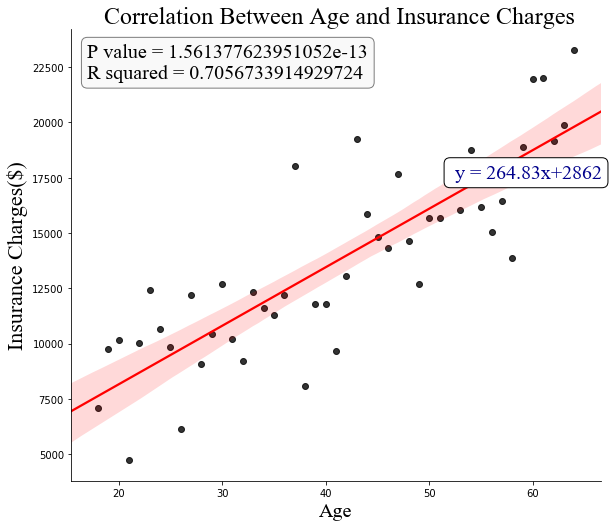

In [14]:
#average Charges by age
avg_by_age = insurance.groupby('age').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_age.age,avg_by_age.charges)
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'

#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between age and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between age and charges".format(p_value))
  

#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""


#textbox properties
box1 = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_age = sns.lmplot(data = avg_by_age, x = 'age', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws = {'color':'black'})
plt.xlabel('Age',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Age and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(52,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(17,22000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)


<b>Conclusion: <br>The above graph clearly indicates that there is a positive correction and the p-value is less than .05. Thus, this variable is statistically significant at 5% level. R_squared is also pretty high around 71%. This means that 71% of the variability in insurance charges can be explained by age: the older you are the more you pay for the insurance. The linear regression equation suggests that you get 1 year older, the charge will be increased by $264.83.  

## b. bmi 
BMI stands for Body Mass Index. This variable is expected to have a high correlation with insurance charages. Let's see if that's the case!

2.1666931918269805e-10 is less than .05. We can conclude that there's some relationship between BMI and charges


Text(15, 59000, 'P value = 2.1666931918269805e-10\nR squared = 0.07123127111893408')

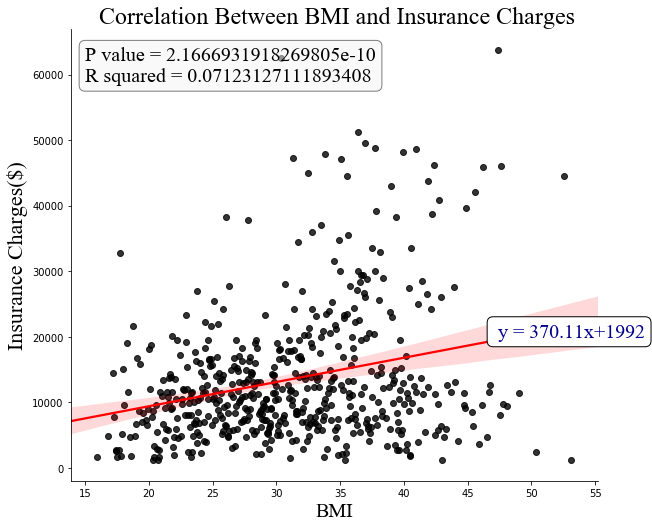

In [15]:
#average Charges by bmi
avg_by_bmi = insurance.groupby('bmi').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_bmi.bmi,avg_by_bmi.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between BMI and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between BMI and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_age = sns.lmplot(data = avg_by_bmi, x = 'bmi', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('BMI',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between BMI and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(47,20000,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(15,59000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br> 
The above graph shows that there is a positive correction between BMI and insurance charge and the p-value is less than .05 so this variable is statistically significant at 5% level. However, R_sqaured is only 7%. This means that only 7% of the variation in insurance charges is explained by BMI, which suggeat that there are many other factors that might be affecting insurance charges. This is interesting because I  thought that BMI would be a great indicator of his/her wellness, which would be highly associated with insurance costs. This is not the case within this dataset. 

## c. sex 
The sex variable is a qualitative predictor with two levels. We will use a dummy variable called sex_n for the analysis

In [16]:
#concatenate predictors with charge 
x_lean_charge = pd.concat([x,y],axis=1)
x_lean_charge

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest,charges
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0,16884.92400
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0,1725.55230
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0,4449.46200
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,21984.47061
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0,10600.54830
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0,2205.98080
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0,1629.83350
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0,2007.94500


0.036132721005929666 is less than .05. We can conclude that there's some relationship between sex and charges


Text(0.2, 58000, 'P value = 0.036132721005929666\nR squared = 0.0032823803913607508')

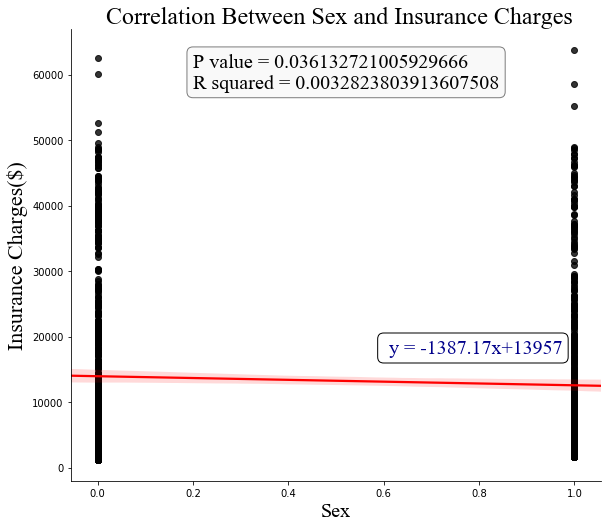

In [17]:
#linear regression equation bewteen sex and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(x_lean_charge.sex_n,x_lean_charge.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between sex and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between sex and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_sex = sns.lmplot(data = x_lean_charge, x = 'sex_n', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('Sex',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Sex and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(.6,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(0.2,58000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br> $y_{i}$ = $\beta_{0}$ +  $\beta_{1}x_{i}$ <br> where $x_{i}$ = 0 if male 1 if female <br><br>1. $\beta_{0}$ can be interpreted as the average insurance charge among male (plug 0 [male for our binary variable] into the equation!). <br> 2. $\beta_{0}$ + $\beta_{1}$ as the average insurance charge among female (plug 0 [male for our binary variable] into the equation!) <br> 3. $\beta_{1}$ as the average difference in insurance charges between male and female <br><br> Thus, the average insruance chage for males is estimated to be $13957, whereas females are estimated to get charged by $1387.17 less for a total of $13957-$1387.17 = $12569.83

## d. children

0.012852128520136412 is less than .05. We can conclude that there's some relationship between children and charges


Text(0.2, 58000, 'P value = 0.012852128520136412\nR squared = 0.004623758854459131')

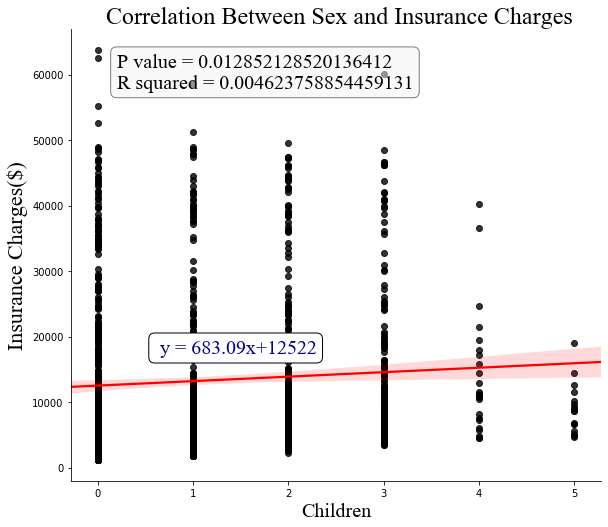

In [18]:
#linear regression equation bewteen children and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(x_lean_charge.children,x_lean_charge.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between children and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between children and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_sex = sns.lmplot(data = x_lean_charge, x = 'children', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('Children',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Sex and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(.6,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(0.2,58000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br>We can reach a similiar conclusion for children as sex. It is statistcally significant, but the R_sqaured is only 0.4% 

## e. Smoker

8.271435842179102e-283 is less than .05. We can conclude that there's some relationship between smoker and charges


Text(0.2, 58000, 'P value = 8.271435842179102e-283\nR squared = 0.6197648148218986')

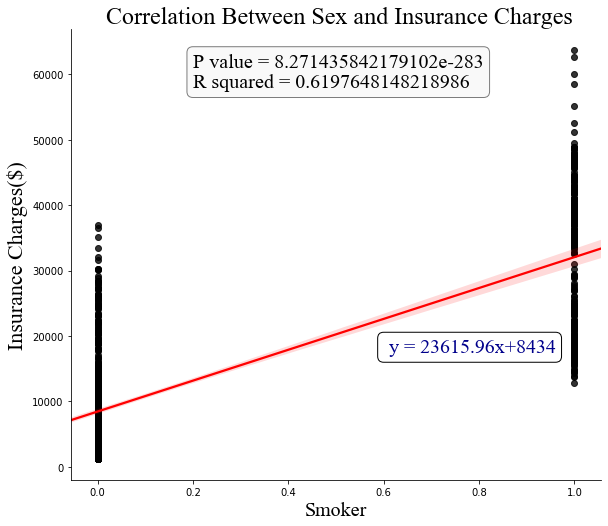

In [19]:
#linear regression equation bewteen children and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(x_lean_charge.smoker_n,x_lean_charge.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between smoker and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between smoker and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_sex = sns.lmplot(data = x_lean_charge, x = 'smoker_n', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('Smoker',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Sex and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(.6,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(0.2,58000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br> All metrics indicate that this variable is one of the important predictors for predicting insurance charges! If you are a smoker, you have to pay $23615 more!! Smokers must quit smoking to be finacially free!
 

<b> Chapter Summary <br>
age, smoker = high effect on insurance charges <br>
sex, bmi, children = low effect on insurance charges<br>

Even though the bottom 3 variable have low effect on insurance charges, I will use them as a predictor for my multiple linear regression since they are at least statistically significant. 
    

# 3. Statistical Method

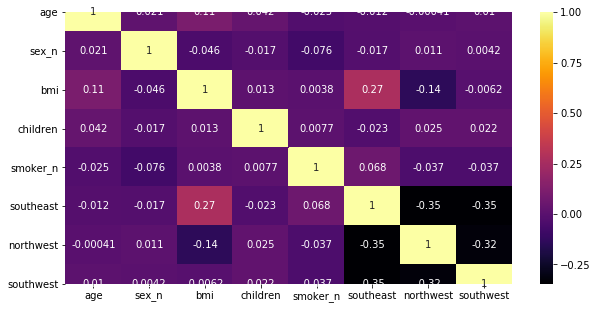

In [20]:
#Correlations between my predictors 
f,ax = plt.subplots(figsize= (10,5))
corr = x_lean.corr()
sns.heatmap(corr, cmap = 'inferno',annot = True)


none of predictors have high correlation among themselves

Before building a model, I will split the data into the training set and the test set. 80% of the data were allocated to the training set

In [21]:
#split the data into training and testing
x_train,x_test,y_train,y_test = train_test_split(x_lean,y,train_size=.8,random_state=5)

#verifying the training and testing data
print(x_train.shape)
print(x_test.shape)

(1070, 8)
(268, 8)


Creating a multiple linear regression model and fit it to my x_train and y_train.

In [22]:
#create an object 
mlr = LinearRegression()

#fit the data
mlr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's find out what the coefficient of determination $r^{2}$ with the test data

In [23]:
mlr.score(x_test,y_test)

0.778109660422383

Let's explore the coefficients of the predictors to see if there's anything we can do to improve the model's accuracy

In [24]:
mlr.coef_

array([  256.94295222,   253.53277438,   337.67931668,   552.8415818 ,
       23660.10485472,  -845.43390866,    56.31627462,  -845.69969435])

In [25]:
person12=[[50,0,27,3,0,0,0,0],[50,1,27,3,0,1,0,0]]

In [26]:
mlr.predict(person12)

array([11377.26249459, 10785.36136031])

In [27]:
predicted_y = mlr.predict(x_test)

In [28]:
predicted_y

array([ 2.80196712e+03,  2.76539583e+04,  1.18270033e+04,  4.97128202e+03,
        8.26020179e+03,  3.49800170e+04,  1.17617005e+04,  1.10656352e+04,
        8.36519245e+03,  1.11807200e+04,  1.54682184e+04,  1.09007670e+04,
        5.01084263e+03,  9.23711837e+03,  8.29646110e+03,  8.89074300e+03,
        3.16202402e+04,  1.29482537e+04,  1.32884644e+04,  7.53128170e+03,
        2.86085344e+04,  2.19240932e+03,  3.24354449e+03,  3.79492040e+03,
        2.49018569e+03,  9.70392727e+03,  3.68406266e+04,  1.70945706e+04,
        1.08592745e+04,  1.40876899e+04,  1.33068247e+04,  1.19355775e+03,
        5.92173822e+03,  1.07504608e+04,  3.11483102e+04,  4.12584954e+03,
        6.66635109e+03,  2.80617764e+03,  6.49691422e+03,  5.82769295e+03,
        3.22789584e+03,  3.72470599e+04,  3.06074251e+04,  3.01806687e+04,
        1.05504381e+04,  7.59258815e+03,  3.50081453e+04,  3.46932792e+03,
        1.90740969e+04,  5.29663474e+03,  1.03836281e+04,  2.86003715e+04,
        3.65718423e+03,  

Text(0, 0.5, 'Predicted insurance charge')

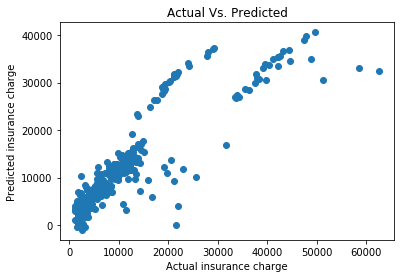

In [29]:
plt.scatter(y_test,predicted_y)
plt.title('Actual Vs. Predicted')
plt.xlabel('Actual insurance charge')
plt.ylabel('Predicted insurance charge')

Based on the graph above and $r^2$, I think my model is fairly effective. Please give me feedback to improve my thought process! Thanks!